## Trabajo 2 Unidad 4 IA
### Reconocimiento de imagenes con torchVision
- Hernán Gallardo
- Juán Pablo Pezo
- Leonardo Rodríguez


In [1]:
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import torch
from torch.utils.data import random_split,DataLoader,TensorDataset
from PIL import Image
import torchvision
import os

### Actividad de CNN

In [2]:
from torchvision import transforms,datasets

transform = transforms.Compose([   # reemplazo
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


path = "pieces"
dataset = datasets.ImageFolder(path,transform=transform)
train_set,val_set,test_set = random_split(dataset,[400,125,126],generator=torch.Generator().manual_seed(619))
train_loader = DataLoader(train_set,batch_size=16,shuffle=True)
val_loader = DataLoader(val_set,batch_size=16,shuffle=True)
test_loader = DataLoader(test_set,batch_size=16,shuffle=True)   

En el siguiente bloque explore la data, con el fin de responder a estas preguntas.  
- ¿De que se trata el dataset?
- ¿Cuales son las clases de salida?
- ¿Cuantas imagenes hay por clase?
- ¿Cual es el tamaño de las imagenes?
- ¿Cuantas imagenes hay en total?
- Grafique algunas imagenes de cada clase
- etc.

El dataset contiene imágenes de piezas de ajedrez.
Clases de salida: ['bishop', 'knight', 'pawn', 'queen', 'rook']
Número de imágenes por clase:
bishop: 141
knight: 174
pawn: 82
queen: 115
rook: 139
Tamaño de las imágenes: torch.Size([3, 224, 224])
Número total de imágenes: 651


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5528543].
Clipping input data to

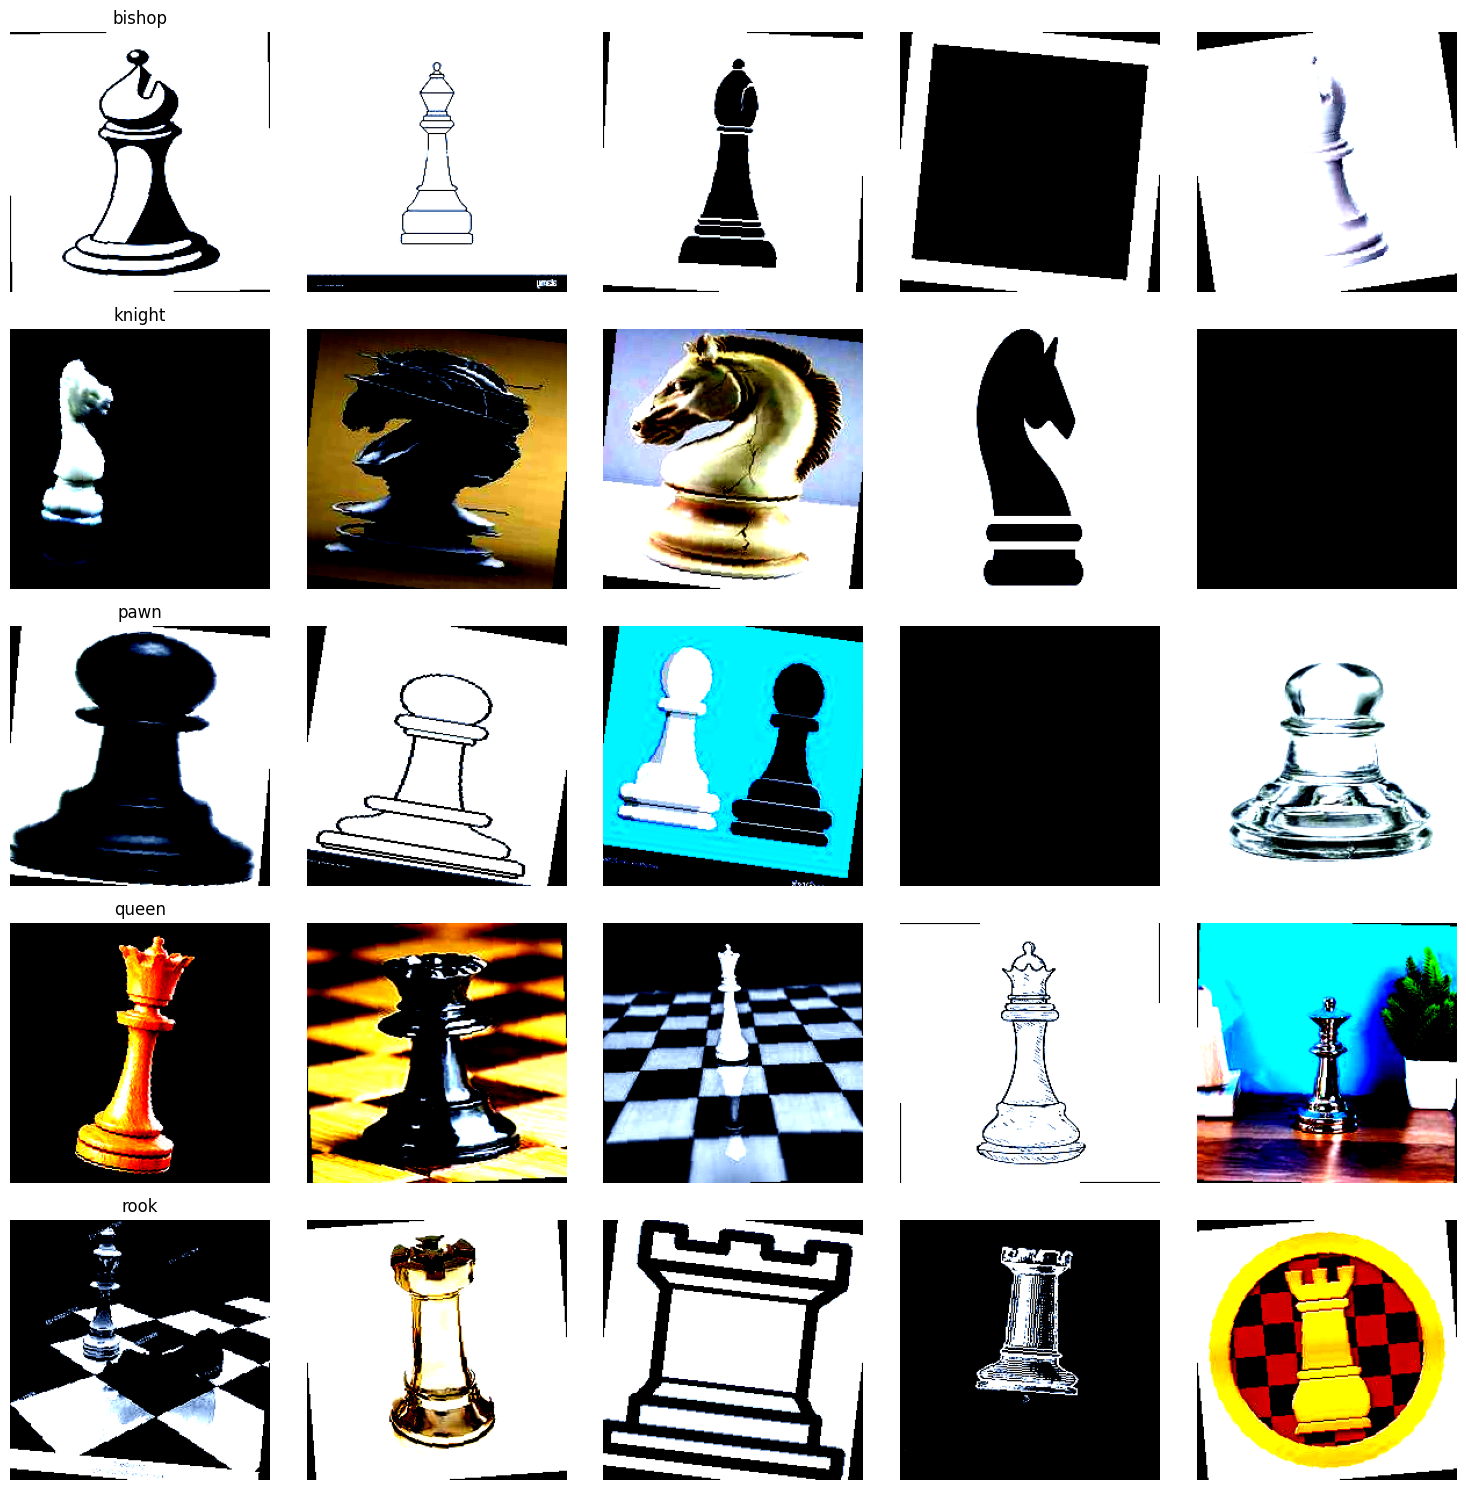


Tamaño del conjunto de entrenamiento: 400
Tamaño del conjunto de validación: 125
Tamaño del conjunto de prueba: 126
Tamaño del lote de entrenamiento: torch.Size([16, 3, 224, 224])

Mapeo de etiquetas numéricas a clases:
0: bishop
1: knight
2: pawn
3: queen
4: rook


In [3]:
# ¿De qué se trata el dataset?
print("El dataset contiene imágenes de piezas de ajedrez.")

# ¿Cuáles son las clases de salida?
classes = dataset.classes
print(f"Clases de salida: {classes}")

# ¿Cuántas imágenes hay por clase?
class_counts = {class_name: len([img for img, label in dataset.samples if dataset.classes[label] == class_name])
                for class_name in classes}
print("Número de imágenes por clase:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

# ¿Cuál es el tamaño de las imágenes?
sample_img, _ = dataset[0]
print(f"Tamaño de las imágenes: {sample_img.shape}")

# ¿Cuántas imágenes hay en total?
total_images = len(dataset)
print(f"Número total de imágenes: {total_images}")

# Visualización de imágenes por clase
def show_images(dataset, classes, num_images=5):
    fig, axes = plt.subplots(len(classes), num_images, figsize=(15, 3*len(classes)))
    for i, class_name in enumerate(classes):
        class_indices = [j for j, (_, label) in enumerate(dataset.samples) if dataset.classes[label] == class_name]
        for j in range(num_images):
            idx = np.random.choice(class_indices)
            img, _ = dataset[idx]
            ax = axes[i][j] if len(classes) > 1 else axes[j]
            ax.imshow(img.permute(1, 2, 0))
            ax.axis('off')
            if j == 0:
                ax.set_title(class_name)
    plt.tight_layout()
    plt.show()

show_images(dataset, classes)

# Información adicional
print(f"\nTamaño del conjunto de entrenamiento: {len(train_set)}")
print(f"Tamaño del conjunto de validación: {len(val_set)}")
print(f"Tamaño del conjunto de prueba: {len(test_set)}")

# Verificar el tamaño de los lotes
for images, labels in train_loader:
    print(f"Tamaño del lote de entrenamiento: {images.shape}")
    break

# Mostrar las etiquetas numéricas y sus correspondientes clases
class_to_idx = dataset.class_to_idx
print("\nMapeo de etiquetas numéricas a clases:")
for class_name, idx in class_to_idx.items():
    print(f"{idx}: {class_name}")

En el siguiente bloque implemente el modelo que le permitirá clasificar las diferentes tipos de piezas en el ajedrez, justifique la arquitectura de la red.

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class ChessPieceClassifier(nn.Module):
    def __init__(self):
        super(ChessPieceClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # añadir
        self.pool = nn.MaxPool2d(2, 2)
        # self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc1 = nn.Linear(256 * 14 * 14, 512) #reemplazo
        self.fc2 = nn.Linear(512, 5)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x))) #añadir
        #x = x.view(-1, 128 * 28 * 28)
        x = x.view(-1, 256 * 14 * 14) # reemplazo
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


### Justificacion:
Entendido. Proporcionaré una explicación completa del modelo actual sin hacer referencia a versiones anteriores.

### Justificación del Modelo ChessPieceClassifier:

1. Arquitectura Convolucional: El modelo utiliza cuatro capas convolucionales (conv1, conv2, conv3, conv4) con un número creciente de filtros (32, 64, 128, 256). Esta estructura permite que la red aprenda características progresivamente más complejas y abstractas de las piezas de ajedrez. El uso de padding=1 en todas las capas convolucionales ayuda a mantener las dimensiones espaciales después de cada convolución.
2. Pooling: Después de cada capa convolucional, se aplica una operación de MaxPooling. Esto reduce la dimensionalidad espacial de los mapas de características, haciendo que la red sea más robusta frente a pequeñas variaciones en las imágenes y reduciendo la cantidad total de parámetros.
3. Capas Completamente Conectadas: Tras las capas convolucionales, la red utiliza dos capas completamente conectadas. La primera tiene 512 neuronas, permitiendo una rica representación de las características extraídas. La capa final tiene 5 neuronas, correspondiendo a las cinco clases de piezas de ajedrez que se están clasificando.
4. Dropout: Se incluye una capa de Dropout con una tasa de 0.5 entre las dos capas completamente conectadas. Esto ayuda a prevenir el sobreajuste, especialmente importante en un modelo con esta profundidad y complejidad.
5. Funciones de Activación: Se utiliza la función ReLU (Rectified Linear Unit) como activación en todas las capas intermedias. ReLU es eficiente computacionalmente y ayuda a manejar no linealidades en el modelo.
6. Dimensiones de Entrada: El modelo está diseñado para manejar imágenes de entrada de 224x224 píxeles con 3 canales de color (RGB).
7. Estructura de Salida: La capa final de 5 neuronas corresponde a las cinco clases de piezas de ajedrez que se están clasificando. Esto permite que el modelo produzca una probabilidad para cada clase.
8. Profundidad y Complejidad: Con cuatro capas convolucionales y dos completamente conectadas, este modelo tiene una profundidad considerable. Esto le permite capturar características muy detalladas y sutiles de las piezas de ajedrez, potencialmente mejorando su capacidad de clasificación.

En resumen, este modelo  es una red neuronal convolucional profunda diseñada específicamente para la tarea de clasificar piezas de ajedrez. Su arquitectura equilibra la capacidad de capturar detalles finos de las imágenes con mecanismos para prevenir el sobreajuste. La combinación de capas convolucionales, pooling, y capas completamente conectadas permite al modelo aprender eficazmente tanto las formas generales como los detalles específicos que diferencian las distintas clases de piezas de ajedrez.
_____________________

En el siguiente bloque cree una instancia de su red neuronal convolucional definida anteriormente y defina una función de perdida y un optimizador.	

In [5]:
device = torch.device("cpu")
print(f"Using device: {device}")

torch.cuda.empty_cache()


Using device: cpu


In [6]:
import torch.optim as optim

model = ChessPieceClassifier().to(device)

In [7]:
criterion = nn.CrossEntropyLoss()
# Utilizamos CrossEntropyLoss(), que es apropiada para problemas de clasificación multiclase.
# Esta función combina LogSoftmax y NLLLoss en una sola clase.  
# Es ideal para nuestro caso, ya que tenemos 5 clases mutuamente excluyentes.

In [8]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Adam es una buena elección general porque adapta la tasa de aprendizaje para cada parámetro,
# lo que lo hace eficiente y efectivo para una amplia gama de problemas.

En el siguiente bloque programe el entrenamiento de su red neuronal convolucional.

In [9]:
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

# Parámetros de entrenamiento
num_epochs = 50  # Aumentado para permitir más tiempo de entrenamiento
patience = 3  # Para early stopping
best_val_loss = float('inf')
counter = 0

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Función para calcular la precisión
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    return correct / labels.size(0)

# Scheduler para ajustar la tasa de aprendizaje
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)

# Bucle de entrenamiento
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_accuracy = 0.0
   
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
       
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Gradient clipping para evitar el problema de exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
       
        train_loss += loss.item() * inputs.size(0)
        train_accuracy += calculate_accuracy(outputs, labels) * inputs.size(0)
   
    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
   
    # Validación
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
   
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
           
            val_loss += loss.item() * inputs.size(0)
            val_accuracy += calculate_accuracy(outputs, labels) * inputs.size(0)
   
    val_loss /= len(val_loader.dataset)
    val_accuracy /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
   
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')
    
    # Ajustar la tasa de aprendizaje
    scheduler.step(val_loss)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break

c:\Users\heru\dev\ia\conv-act-ia\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/50], Train Loss: 1.7033, Train Acc: 0.2250, Val Loss: 1.6069, Val Acc: 0.1840
Epoch [2/50], Train Loss: 1.6125, Train Acc: 0.2250, Val Loss: 1.5840, Val Acc: 0.2800
Epoch [3/50], Train Loss: 1.6010, Train Acc: 0.2700, Val Loss: 1.5768, Val Acc: 0.2800
Epoch [4/50], Train Loss: 1.5920, Train Acc: 0.2875, Val Loss: 1.5617, Val Acc: 0.2960
Epoch [5/50], Train Loss: 1.5542, Train Acc: 0.3125, Val Loss: 1.5644, Val Acc: 0.3600
Epoch [6/50], Train Loss: 1.4327, Train Acc: 0.3850, Val Loss: 1.4206, Val Acc: 0.4400
Epoch [7/50], Train Loss: 1.2861, Train Acc: 0.4825, Val Loss: 1.3438, Val Acc: 0.4800
Epoch [8/50], Train Loss: 1.1479, Train Acc: 0.5475, Val Loss: 1.3376, Val Acc: 0.4880
Epoch [9/50], Train Loss: 1.0616, Train Acc: 0.5850, Val Loss: 1.3526, Val Acc: 0.4800
Epoch [10/50], Train Loss: 0.9364, Train Acc: 0.6575, Val Loss: 1.4245, Val Acc: 0.5120
Epoch [11/50], Train Loss: 0.8581, Train Acc: 0.7025, Val Loss: 1.4789, Val Acc: 0.4800
Early stopping


En el siguiente bloque muestre el gráfico de entrenamiento y validación de su red neuronal convolucional.

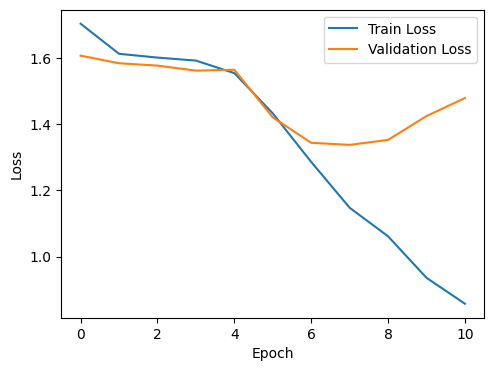

In [10]:
# Gráfico de pérdida y precisión
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Muestre diferentes métricas de evaluación de su red neuronal convolucional.

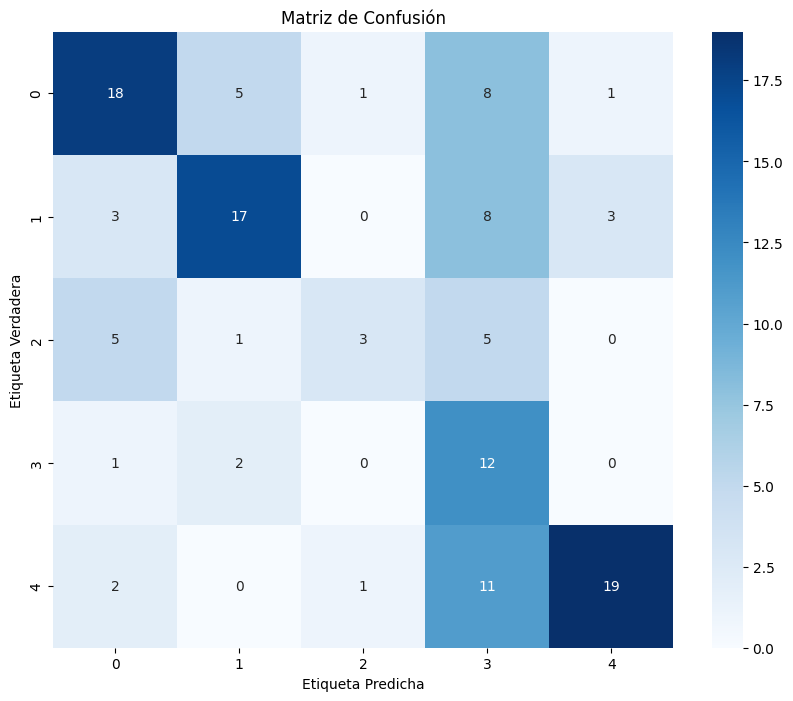


Informe de Clasificación:
              precision    recall  f1-score   support

      bishop       0.62      0.55      0.58        33
      knight       0.68      0.55      0.61        31
        pawn       0.60      0.21      0.32        14
       queen       0.27      0.80      0.41        15
        rook       0.83      0.58      0.68        33

    accuracy                           0.55       126
   macro avg       0.60      0.54      0.52       126
weighted avg       0.65      0.55      0.56       126


Métricas Generales:
Pérdida en el conjunto de prueba: 1.3956
Exactitud (Accuracy): 0.5476
Precisión ponderada: 0.6454
Recall ponderado: 0.5476
F1-Score ponderado: 0.5627


In [11]:
import torch
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    all_predictions = []
    all_labels = []
    test_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            test_loss += loss.item() * inputs.size(0)
    
    test_loss /= len(test_loader.dataset)
    
    # Convertir listas a arrays de numpy
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    
    # Calcular métricas
    accuracy = accuracy_score(all_labels, all_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')
    
    # Crear y mostrar la matriz de confusión
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Matriz de Confusión')
    plt.ylabel('Etiqueta Verdadera')
    plt.xlabel('Etiqueta Predicha')
    plt.show()
    
    # Mostrar el informe de clasificación
    class_names = test_loader.dataset.dataset.classes  # Asumiendo que usas ImageFolder
    print("\nInforme de Clasificación:")
    print(classification_report(all_labels, all_predictions, target_names=class_names))
    
    # Mostrar métricas generales
    print(f"\nMétricas Generales:")
    print(f"Pérdida en el conjunto de prueba: {test_loss:.4f}")
    print(f"Exactitud (Accuracy): {accuracy:.4f}")
    print(f"Precisión ponderada: {precision:.4f}")
    print(f"Recall ponderado: {recall:.4f}")
    print(f"F1-Score ponderado: {f1:.4f}")
    
    return test_loss, accuracy, precision, recall, f1

# Asumiendo que ya tienes tu modelo entrenado y tu test_loader
model.to(device)
criterion = nn.CrossEntropyLoss()

test_loss, accuracy, precision, recall, f1 = evaluate_model(model, test_loader, criterion, device)

### Concluya sobre las métricas obtenidas y el entrenamiento de su red neuronal convolucional.
El modelo de clasificación de piezas de ajedrez muestra un rendimiento moderado, con una exactitud global del 54%. Las torres y los caballos se clasifican relativamente bien, mientras que los peones presentan el mayor desafío. Existe un equilibrio general entre precisión y exhaustividad, aunque hay variaciones entre las diferentes clases de piezas. La pérdida en el conjunto de prueba es algo elevada, lo que sugiere que aún hay margen de mejora.
Podemos concluir que el modelo ha aprendido patrones útiles, pero necesita ser refinado. Para mejorar su rendimiento, se podrían considerar estrategias como aumentar el conjunto de datos, especialmente para las clases con menor rendimiento, implementar técnicas de aumento de datos, ajustar la arquitectura del modelo o los hiperparámetros, e investigar posibles desequilibrios en el conjunto de datos.

En el siguiente bloque muestre las predicciones de su red neuronal convolucional y responda:
- ¿Cree que los errores son razonables?
- ¿Qué haría para mejorar la clasificación de las piezas de ajedrez?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.193377].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


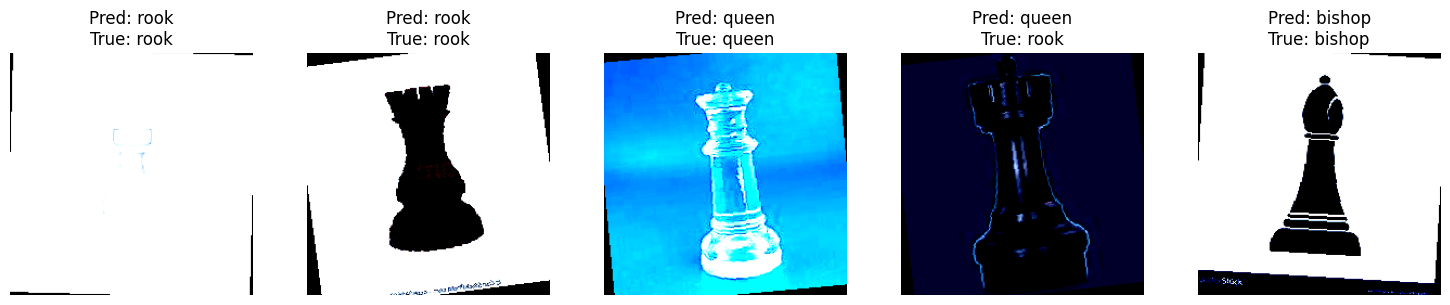

In [12]:
def show_predictions(model, test_loader, class_names, num_images=5):
    model.eval()
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            if i >= num_images:
                break
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            ax = axes[i]
            img = inputs[0].cpu().permute(1, 2, 0)
            ax.imshow(img)
            ax.set_title(f'Pred: {class_names[predicted[0]]}\nTrue: {class_names[labels[0]]}')
            ax.axis('off')
    plt.tight_layout()
    plt.show()

show_predictions(model, test_loader, dataset.classes)

### ¿Cree que los errores son razonables?
Los errores son medianamente razonables dado el tamaño limitado del dataset y la similitud visual entre algunas piezas de ajedrez. Sin embargo, el rendimiento actual sugiere que hay espacio significativo para mejoras.

### ¿Qué haría para mejorar la clasificación de las piezas de ajedrez?
Para mejorar la clasificación:

- Aumentar el tamaño del dataset mediante técnicas de aumento de datos (rotaciones, flips, cambios de contraste).
- Utilizar transfer learning con un modelo preentrenado.
- Implementar técnicas de balanceo de clases para abordar el desempeño desigual.
- Experimentar con arquitecturas de red más complejas o modernas (ResNet, EfficientNet).
- Ajustar hiperparámetros como la tasa de aprendizaje, tamaño de lote y número de épocas.
- Aplicar técnicas de regularización más agresivas para prevenir el sobreajuste.